In [1]:
#Import Files / Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Install new libraries
!pip install spectral

In [3]:
#Import Libraries

import spectral as sp
import spectral.io.envi as envi

import numpy as np
import scipy as sc

import pandas as pd

import sklearn
import skimage
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from skimage.restoration import denoise_wavelet
from skimage import img_as_float
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
# sns.set()

import joblib

#Set function to convert into rgb image
def to_rgb(x):
    dim = x.shape[-1]
    bands_section = int(dim/3)
    bands = [bands_section,(dim+bands_section)//2,dim-1]
    rgb = x[...,bands]
    for i in range(3):
        l,u = rgb[...,i].min(), rgb[...,i].max()
        rgb[...,i] = (rgb[...,i] - l) / (u - l)
    return np.clip(rgb,0,1)

## Read / Set the data

/usr/local/lib/python3.10/dist-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(843, 221, 288)


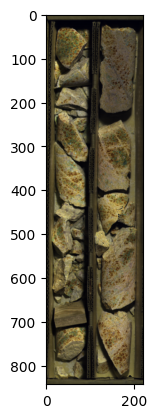

In [4]:
#Input data Image 1

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/VNIR AND SWIR interval/CMM-111_195_extracted_image.img'

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.raw'


#Open image with envi
img = envi.open(hdrFile1, imgFile1)

#Load image
hypr_c195 = img.load()

hypr_c195.shape

#Image shape
hypr_shape = hypr_c195.shape

#Set index
index = hypr_shape[-1]

#Set RGB image for plotting
img_rgb = to_rgb(hypr_c195)

#Load image
plt.imshow(img_rgb)

print(hypr_shape)

#Set image for rest of calculations
hypr = hypr_c195

## Reshape: Original Image


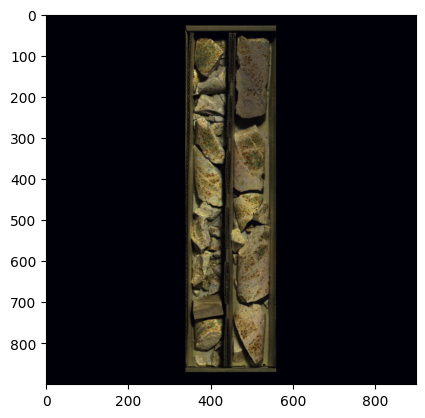

In [5]:
# Load your original hyperspectral image (replace with your own data loading code)
#hypr_c195 = load_hyperspectral_image()  # Replace with your data loading code

#Set index =
index = 288

# Define the target size
target_size = (900, 900, index)

# Create an empty array with the target size
padded_image = np.zeros(target_size, dtype=hypr_c195.dtype)

# Calculate the padding on each side
y_pad = (target_size[0] - hypr_c195.shape[0]) // 2
x_pad = (target_size[1] - hypr_c195.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_image[y_pad:y_pad + hypr_c195.shape[0], x_pad:x_pad + hypr_c195.shape[1]] = hypr_c195

#Set RGB image for plotting
img_rgb = to_rgb(padded_image)

#Load image
plt.imshow(img_rgb)

In [6]:
original_shape = padded_image.shape[:-1]+(5,)

#Apply the first mask pipeline (Data X Hyperspectral with first mask)
H_padded = padded_image.reshape(-1, 288)
#H = H[:,swir_range]
H_padded = pl2.transform(H_padded)

H_padded = H_padded.reshape(original_shape)

H_padded.shape

NameError: name 'pl2' is not defined

#Finer masking (Apply and Select Kernel Mask 2)

In [6]:
#Open masks

#Path to .tiff mask file
tiffFileMask1 = '/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/B039 b_ref.png'

#Read image with plt
mask_c195 = plt.imread(tiffFileMask1)

#print('mask1:',mask_c195.shape)

#print(mask_c195)

#Select just the image first three channels: [:,:,:3]
mask_c195 = rgb2gray(mask_c195[:,:,:3]).astype(bool)


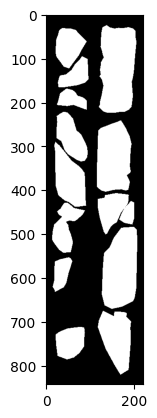

In [7]:
plt.imshow(mask_c195, cmap='binary_r')

#Results are boolean array

In [8]:
#Set labels
y  = mask_c195.reshape(-1)

#Set image:
#H = hypr_c195.reshape(-1, hypr_shape[-1])

## Reshape: Final Mask

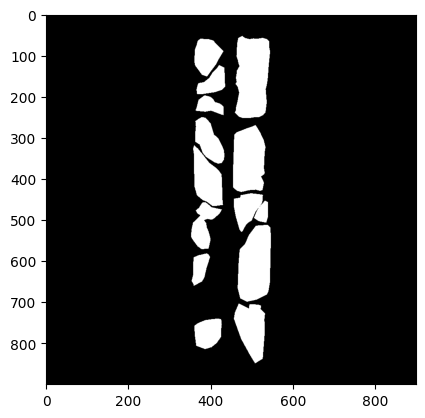

In [9]:
target_mask = (900, 900)

# Create an empty array with the target size
padded_mask = np.zeros(target_mask)

# Calculate the padding on each side
y_pad = (target_size[0] - mask_c195.shape[0]) // 2
x_pad = (target_size[1] - mask_c195.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_mask[y_pad:y_pad + mask_c195.shape[0], x_pad:x_pad + mask_c195.shape[1]] = mask_c195

#Set RGB image for plotting
#img_rgb_mask = to_rgb(padded_mask)

#Load image
plt.imshow(padded_mask, cmap='binary_r')

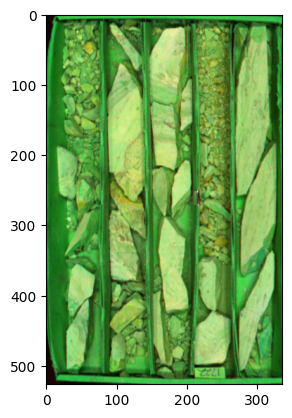

In [10]:
#Input data Image 1

#Path of hdr file image1
hdrFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/CMM-111_195.hdr'

#Path of img file image1
imgFile1='/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/CMM-111_195.img'

#Open image with envi
hypr2 = envi.open(hdrFile1, imgFile1)

#Load image
hypr2 = hypr2.load()

hypr2_OG = hypr2.copy()

img3_rgb=sp.get_rgb(hypr2 )

plt.imshow(img3_rgb)

In [11]:
index = hypr2.shape[-1]

#Reshape and select just SWIR wavelenghts
hypr2  = hypr2 .reshape(-1, index)

#Principal Component Analysis, Dimensionality Reduction to 5 dimensions
pca = TruncatedSVD(n_components=5)

#Pipleline: Automates preprocessing steps
#Standarized data values into standard format,
pl2  = Pipeline([('scale',StandardScaler()),('pca',pca)])
hyprT2 = pl2.fit_transform(hypr2)


#Apply the first mask pipeline (Data X Hyperspectral with first mask)
H2 = hypr2.reshape(-1, index)
#H = H[:,swir_range]
H2 = pl2.transform(H2)

H2.shape

(177599, 5)

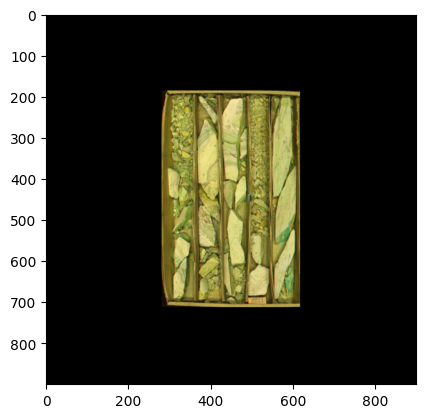

In [12]:
# Load your original hyperspectral image (replace with your own data loading code)
#hypr_c195 = load_hyperspectral_image()  # Replace with your data loading code

#Set index =

# Define the target size
target_size = (900, 900, index)

# Create an empty array with the target size
padded_image2 = np.zeros(target_size, dtype=hypr2_OG.dtype)

# Calculate the padding on each side
y_pad = (target_size[0] - hypr2_OG.shape[0]) // 2
x_pad = (target_size[1] - hypr2_OG.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_image2[y_pad:y_pad + hypr2_OG.shape[0], x_pad:x_pad + hypr2_OG.shape[1]] = hypr2_OG

#Set RGB image for plotting
img_rgb2 = to_rgb(padded_image2)

#Load image
#Load image
plt.imshow(img_rgb2)

In [13]:
padded_image2.shape

(900, 900, 411)

In [14]:
# Reshape back to the original shape
original_shape = padded_image2.shape[:-1]+(5,)  # Assuming padded_image2 is the original image


In [15]:
#Reshape and select just SWIR wavelenghts
padded_image2  = padded_image2 .reshape(-1, index)

#Principal Component Analysis, Dimensionality Reduction to 5 dimensions
pca = TruncatedSVD(n_components=5)

#Pipleline: Automates preprocessing steps
#Standarized data values into standard format,
pl2  = Pipeline([('scale',StandardScaler()),('pca',pca)])
hyprT2 = pl2.fit_transform(padded_image2)

print(padded_image2.shape)


# Reshape back to the original shape

#Apply the first mask pipeline (Data X Hyperspectral with first mask)
H_padded2 = padded_image2.reshape(-1, index)
#H = H[:,swir_range]
H_padded2 = pl2.transform(H_padded2)

H_padded2 = H_padded2.reshape(original_shape)

H_padded2.shape

(810000, 411)


(900, 900, 5)

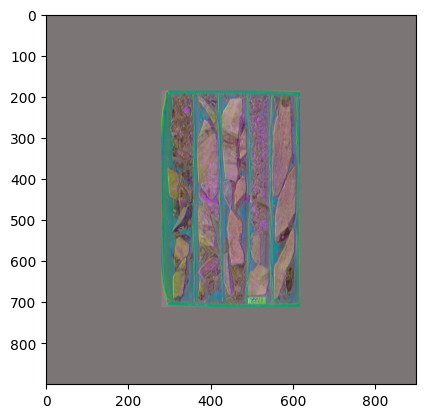

In [16]:
#Set RGB image for plotting
img_rgb2 = to_rgb(H_padded2)
plt.imshow(img_rgb2)

mask1: (527, 337, 4)
mask1: (527, 337)


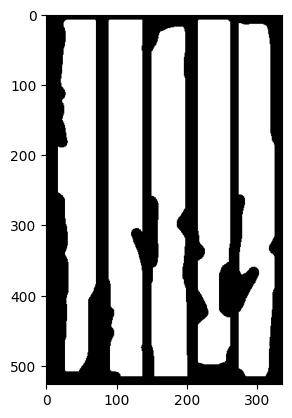

In [17]:

#Open masks

#Path to .tiff mask file
tiffFileMask2 = '/content/drive/MyDrive/SURF/HySpectral Project/data/training_data/training_data_2023/CMM-111_195.tiff'

#Read image with plt
mask_2 = plt.imread(tiffFileMask2)

print('mask1:',mask_2.shape)

#print(mask_c195)

#Select just the image first three channels: [:,:,:3]
mask_2 = rgb2gray(mask_2[:,:,:3]).astype(bool)

plt.imshow(mask_2, cmap='binary_r')

print('mask1:',mask_2.shape)

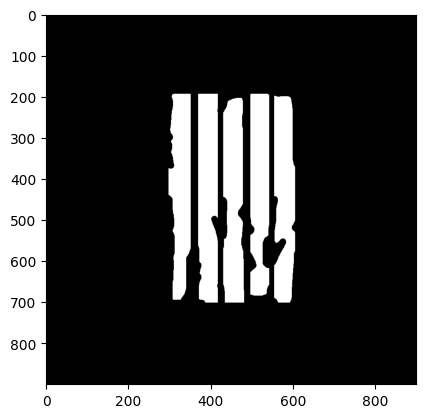

In [18]:

target_mask = (900, 900)

# Create an empty array with the target size
padded_mask2 = np.zeros(target_mask)

# Calculate the padding on each side
y_pad = (target_size[0] - mask_2.shape[0]) // 2
x_pad = (target_size[1] - mask_2.shape[1]) // 2

# Copy the original image to the center of the padded image
padded_mask2[y_pad:y_pad + mask_2.shape[0], x_pad:x_pad + mask_2.shape[1]] = mask_2

#Set RGB image for plotting
#img_rgb_mask = to_rgb(padded_mask)

#Load image
plt.imshow(padded_mask2, cmap='binary_r')

In [19]:
# Combine data
XTrain = [H_padded, H_padded2]
# Concatenate the two sets of features along the second axis (axis=1)
X_combined = np.concatenate(XTrain, axis=0)

# Concatenate the two sets of labels along the second axis (axis=1)
y_combined = np.concatenate((padded_mask, padded_mask2), axis=None)

NameError: name 'H_padded' is not defined

#Open more images and masks

## CNN Model

Train Model with Image 1 and the final mask above.


In [20]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time

np.random.seed(0)
tf.random.set_seed(0)

In [21]:
# Define constants
num_kernels = 16
dense_layer_neurons = 64
kernels_size = (3, 3)
pooling_size = (2, 2)
image_shape = original_shape  # Assuming images have shape (900, 900, 5)


In [45]:
hypr = H_padded2
mask = padded_mask2

#hypr2 = H_padded
#mask2 = padded_mask

In [38]:
# Assuming hypr is your single image
# Assuming mask is your label data
hypr = hypr.reshape((1,) + hypr.shape)  # Adding a batch dimension
#hypr = hypr.reshape((1,) + hypr.shape)

mask = mask.reshape((1,) + mask.shape + (1,))
#mask = mask.reshape((1,) + mask.shape + (1,))

#hypr2 = hypr2.reshape((1,) + hypr2.shape)  # Adding a batch dimension
#hypr2 = hypr2.reshape((1,) + hypr2.shape)

#mask2 = mask2.reshape((1,) + mask2.shape + (1,))
#mask2 = mask2.reshape((1,) + mask2.shape + (1,))

# Convert to TensorFlow tensors
hypr_T = tf.convert_to_tensor(hypr, dtype=tf.float32)
mask_T = tf.convert_to_tensor(mask, dtype=tf.float32)  # Use dtype=tf.bool for boolean labels

#hypr2 = tf.convert_to_tensor(hypr2, dtype=tf.float32)
#mask2 = tf.convert_to_tensor(mask2, dtype=tf.float32)

# Create a dataset from the single image and its corresponding label
dataset_train = tf.data.Dataset.from_tensor_slices((hypr, mask))

# Shuffle and batch the dataset (adjust batch size as needed)
batch_size = 32
dataset_train = dataset_train.shuffle(buffer_size=1).batch(batch_size)

# Now, you can use dataset_train to train your model

In [46]:
print(hypr.shape)
print(mask.shape)


(900, 900, 5)
(900, 900)


In [51]:
hypr = H_padded2
mask = padded_mask2


# Remove the extra dimension from the images
hypr_list = np.array([hypr, hypr])
mask_list = np.array([mask, mask])

# Create a dataset from multiple images and their corresponding labels
dataset_train = tf.data.Dataset.from_tensor_slices((hypr_list, mask_list))

# Shuffle and batch the dataset (adjust batch size as needed)
batch_size = 32
dataset_train = dataset_train.shuffle(buffer_size=2).batch(batch_size)

# Verify the shapes of the first batch in the dataset
for batch in dataset_train.take(1):
    hypr_batch, mask_batch = batch
    print("Input shape:", hypr_batch.shape)
    print("Target shape:", mask_batch.shape)

Input shape: (2, 900, 900, 5)
Target shape: (2, 900, 900)


In [52]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 900, 900, 5), dtype=tf.float32, name=None), TensorSpec(shape=(None, 900, 900), dtype=tf.float64, name=None))>

In [49]:
# Assuming you have defined your model and compiled it
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(900, 900, 5)),

    # Encoder
    tf.keras.layers.Conv2D(num_kernels, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=pooling_size, padding='same'),
    tf.keras.layers.Conv2D(num_kernels * 2, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=pooling_size, padding='same'),

    # Decoder
    tf.keras.layers.Conv2DTranspose(num_kernels * 2, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(size=pooling_size),
    tf.keras.layers.Conv2DTranspose(num_kernels, kernels_size, activation='relu', padding='same'),
    tf.keras.layers.UpSampling2D(size=pooling_size),

    # Output layer
    tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same'),  # Sigmoid activation for binary classification
])

# Print the summary of the model
model.summary()

# Compile the model
model.compile(
    loss='binary_crossentropy',  # Binary cross-entropy loss for binary classification
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)

# Set the number of epochs (you can adjust this based on your needs)
epochs = 50

# Train the model
history = model.fit(dataset_train, epochs=epochs, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 900, 900, 16)      736       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 450, 450, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 450, 450, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 225, 225, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 225, 225, 32)      9248      
 Transpose)                                                      
                                                      

KeyboardInterrupt: 

# Results / Predictions

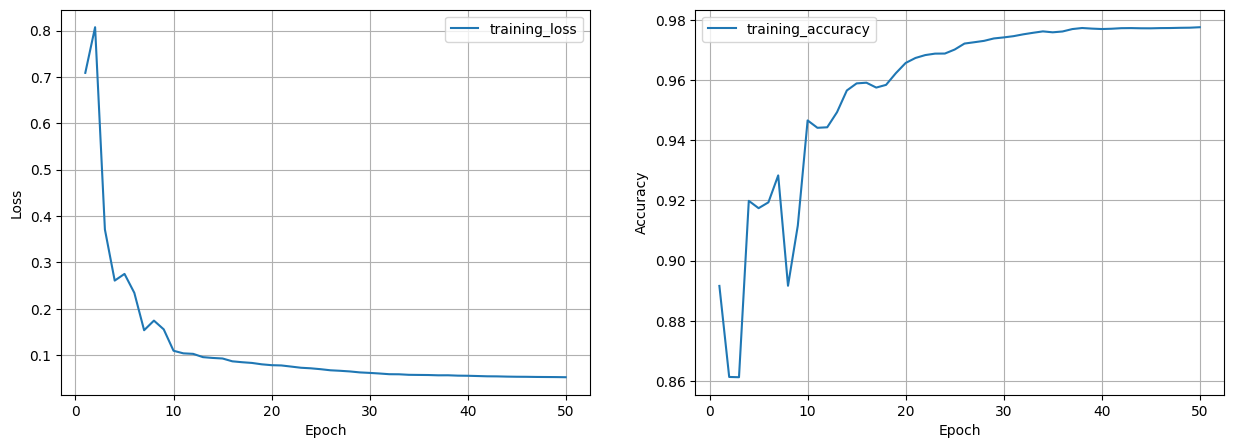

In [122]:
# Ploting results function:

def plot_results(history):
    epoch_num = np.arange(1, len(history.history['loss'])+1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_num, history.history['loss'], label='training_loss')
#    plt.plot(epoch_num, history.history['val_loss'], label='test_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epoch_num, history.history['accuracy'], label='training_accuracy')
#    plt.plot(epoch_num, history.history['val_accuracy'], label='test_accuracy')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)

# Plot results and print summary
plot_results(history)


1/1 [==============================] - 1s 940ms/step
(1, 900, 900, 1)


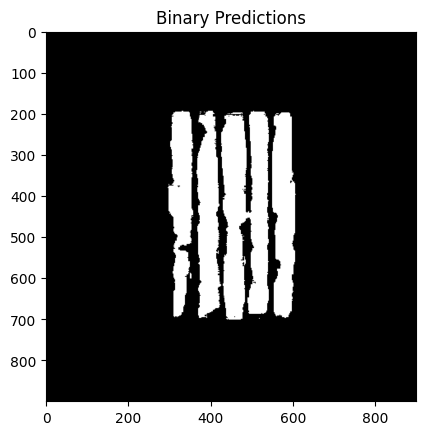

In [150]:
# Assuming hypr is your single image
# Assuming mask is your label data
hypr2 = H_padded2.reshape((1,) + H_padded2.shape)  # Adding a batch dimension

# Convert to TensorFlow tensors
hypr2 = tf.convert_to_tensor(hypr2, dtype=tf.float32)

predictions = model.predict(hypr2)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

#Print shape
print(binary_predictions.shape)

# Assuming binary_predictions is your model's binary output
binary_predictions_reshaped = binary_predictions.reshape((900, 900))

# Plot the reshaped binary predictions
plt.imshow(binary_predictions_reshaped, cmap='gray')
plt.title('Binary Predictions')
plt.show()

In [124]:
# Assuming hypr is your single image
# Assuming mask is your label data
hypr = H_padded.reshape((1,) + H_padded2.shape)  # Adding a batch dimension

# Convert to TensorFlow tensors
hypr = tf.convert_to_tensor(hypr, dtype=tf.float32)

predictions = model.predict(hypr)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

#Print shape
print(binary_predictions.shape)

# Assuming binary_predictions is your model's binary output
binary_predictions_reshaped = binary_predictions.reshape((900, 900))

# Plot the reshaped binary predictions
plt.imshow(binary_predictions_reshaped, cmap='gray')
plt.title('Binary Predictions')
plt.show()

ValueError: cannot reshape array of size 233280000 into shape (1,900,900,5)